In [1]:
# prompt: mount to drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/DL/RNN
!ls

/content/drive/MyDrive/DL/RNN
'IMDB Dataset Cleaned2.csv'  'IMDB Dataset.csv'
'IMDB Dataset Cleaned.csv'    RNN.ipynb


In [3]:
!pip install  nltk emoji pyspellchecker


In [4]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

# Load dữ liệu
df = pd.read_csv("IMDB Dataset.csv")
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Here Come ChatWords Which i Get from a Github Repository
# Repository Link : https://github.com/rishabhverma17/sms_slang_translator/blob/master/slang.txt
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

In [6]:
import re
def remove_html_tags(text):
    pattern = re.compile('<.*?>')
    return pattern.sub(r'', text)

def remove_url(text):
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'', text)

import string,time
string.punctuation

exclude = string.punctuation

def remove_punc(text):
    return text.translate(str.maketrans('', '', exclude))


def chat_conversion(text):
    new_text = []
    for w in text.split():
        if w.upper() in chat_words:
            new_text.append(chat_words[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

from spellchecker import SpellChecker

def correct_spelling(text):
    spell = SpellChecker()
    words = text.split()
    corrected = [spell.correction(word) for word in words]
    # Handle cases where spell.correction returns None by using the original word
    corrected_words = [corrected_word if corrected_word is not None else original_word for corrected_word, original_word in zip(corrected, words)]
    return ' '.join(corrected_words)

from nltk.corpus import stopwords

def remove_stopwords(text):
    new_text = []

    for word in text.split():
        if word in stopwords.words('english'):
            new_text.append('')
        else:
            new_text.append(word)
    x = new_text[:]
    new_text.clear()
    return " ".join(x)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
import emoji
print(emoji.demojize('NLP is 🔥'))

from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()

# This Function Will Stem Words
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

NLP is :fire:


In [7]:
def text_cleaning(text):
    text = remove_html_tags(text)
    text = remove_url(text)
    text = emoji.demojize(text)
    # text = remove_emoji(text)
    text = chat_conversion(text)
    # text = correct_spelling(text)  ### !!!!very low. don't use
    text = remove_punc(text)
    text = text.lower()
    text = stem_words(text)
    text = remove_stopwords(text)
    return text

In [8]:
df['review'] = df['review'].apply(text_cleaning)
df.to_csv('IMDB Dataset Cleaned2.csv', index=False)

In [8]:
df = pd.read_csv('IMDB Dataset Cleaned.csv')
df.head(5)

,review,sentiment
0,one review ha mention watch 1 oz episod ...,1
1,wonder littl product film techniqu veri una...,1
2,thought thi wa wonder way spend tear eye ...,1
3,basic famili littl boy jake think zombi ...,0
4,petter mattei love tear eye money visua...,1


In [9]:

# Tách dữ liệu
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=42)

from collections import Counter

def tokenize(text):
    return word_tokenize(text)

# Xây dựng vocab từ training set
counter = Counter()
for text in X_train:
    counter.update(tokenize(text))

vocab = {'<PAD>': 0, '<UNK>': 1}
for word, freq in counter.items():
    if freq >= 5:
        vocab[word] = len(vocab)

def encode(text, vocab, max_len=200):
    tokens = tokenize(text)
    ids = [vocab.get(token, vocab['<UNK>']) for token in tokens[-max_len:]]
    return [vocab['<PAD>']] * (max_len - len(ids)) + ids


In [10]:
class IMDBDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len=200):
        self.texts = texts
        self.labels = labels.values
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        x = encode(self.texts.iloc[idx], self.vocab, self.max_len)
        y = self.labels[idx]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.float)

train_dataset = IMDBDataset(X_train, y_train, vocab)
test_dataset = IMDBDataset(X_test, y_test, vocab)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


In [11]:
import torch.nn as nn

class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_dim=64):
        super(SentimentRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return self.sigmoid(out).squeeze()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SentimentRNN(vocab_size=len(vocab)).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

SentimentRNN(
  (embedding): Embedding(27513, 64, padding_idx=0)
  (lstm): LSTM(64, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [12]:
# prompt: tham số từng lớp

def count_parameters(model):
    """
    Prints the number of trainable parameters for each layer in a PyTorch model.
    """
    print("Trainable parameters per layer:")
    total_params = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            num_params = param.numel()
            print(f"{name}: {num_params}")
            total_params += num_params
    print(f"Total trainable parameters: {total_params}")

count_parameters(model)


Trainable parameters per layer:
embedding.weight: 1760832
lstm.weight_ih_l0: 16384
lstm.weight_hh_l0: 16384
lstm.bias_ih_l0: 256
lstm.bias_hh_l0: 256
fc.weight: 64
fc.bias: 1
Total trainable parameters: 1794177


In [13]:
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return correct / total

Epoch 1, Loss: 0.5344
Epoch 1, Accuracy: 0.8232
Epoch 2, Loss: 0.3644
Epoch 2, Accuracy: 0.8377
Epoch 3, Loss: 0.2940
Epoch 3, Accuracy: 0.8477
Epoch 4, Loss: 0.2303
Epoch 4, Accuracy: 0.8693
Epoch 5, Loss: 0.2122
Epoch 5, Accuracy: 0.8656
Epoch 6, Loss: 0.1667
Epoch 6, Accuracy: 0.8745
Epoch 7, Loss: 0.1319
Epoch 7, Accuracy: 0.8785
Epoch 8, Loss: 0.1073
Epoch 8, Accuracy: 0.8784
Epoch 9, Loss: 0.0864
Epoch 9, Accuracy: 0.8750
Epoch 10, Loss: 0.0638
Epoch 10, Accuracy: 0.8712


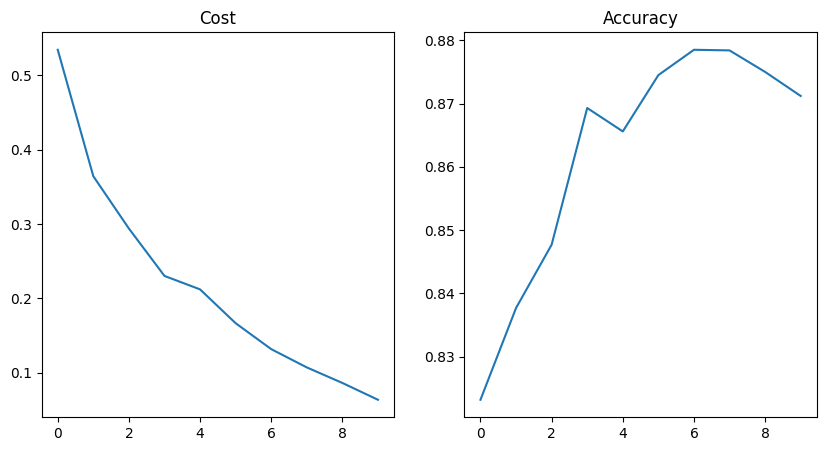

In [14]:
import matplotlib.pyplot as plt
import numpy as np

costs = []
accs = []

# Train loop
for epoch in range(10):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")
    costs.append(total_loss/len(train_loader))
    accs.append(evaluate(model, test_loader))
    print(f"Epoch {epoch+1}, Accuracy: {evaluate(model, test_loader):.4f}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(np.squeeze(costs))
plt.title('Cost')
plt.subplot(1, 2, 2)
plt.plot(np.squeeze(accs))
plt.title('Accuracy')
plt.show()


In [15]:
def predict(text):
    model.eval()
    encoded = torch.tensor([encode(text, vocab)], dtype=torch.long).to(device)
    with torch.no_grad():
        output = model(encoded)
        return "Positive" if output.item() > 0.5 else "Negative"

print(predict(text_cleaning("The movie was awesome and very touching.")))


Positive
